# Identification des facteurs de risque avec NLP

In [1]:
!pip3 install yellowbrick

    100% |████████████████████████████████| 266kB 1.5MB/s ta 0:00:01
You are using pip version 19.0.3, however version 20.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
pip install --upgrade pip yellowbrick

     |████████████████████████████████| 1.5MB 1.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/13/95/a14e4fdfb8b1c8753bbe74a626e910a98219ef9c87c6763585bbd30d84cf/yellowbrick-1.1-py3-none-any.whl
  Found existing installation: pip 19.2.3
    Uninstalling pip-19.2.3:
      Successfully uninstalled pip-19.2.3
Note: you may need to restart the kernel to use updated packages.


In [14]:
root_path = '/Users/youssefbrachmi/Desktop/Projets/COVID-19/Risk factors/CORD-19-research-challenge/'

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
import json
import os
import yellowbrick
import glob

from pos_viz import PosTagVisualizer

#nltk.download("averaged_perceptron_tagger")
#nltk.download("tagsets")

random.seed(52)

%matplotlib inline

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/youssefbrachmi/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/youssefbrachmi/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


# Chargement du fichier metadata 


In [23]:
metadata_path = f'{root_path}/metadata.csv'
meta_df = pd.read_csv(metadata_path, dtype={
    'pubmed_id': str,
    'Microsoft Academic Paper ID': str, 
    'doi': str
})
meta_df.head()

cord_uid                                       sha source_x  \
0  zjufx4fo  b2897e1277f56641193a6db73825f707eed3e4c9      PMC   
1  ymceytj3  e3d0d482ebd9a8ba81c254cc433f314142e72174      PMC   
2  wzj2glte  00b1d99e70f779eb4ede50059db469c65e8c1469      PMC   
3  2sfqsfm1  cf584e00f637cbd8f1bb35f3f09f5ed07b71aeb0      PMC   
4  i0zym7iq  dde02f11923815e6a16a31dd6298c46b109c5dfa      PMC   

                                               title  \
0  Sequence requirements for RNA strand transfer ...   
1  Crystal structure of murine sCEACAM1a[1,4]: a ...   
2  Synthesis of a novel hepatitis C virus protein...   
3  Structure of coronavirus main proteinase revea...   
4  Discontinuous and non-discontinuous subgenomic...   

                        doi      pmcid pubmed_id license  \
0  10.1093/emboj/20.24.7220  PMC125340  11742998     unk   
1   10.1093/emboj/21.9.2076  PMC125375  11980704     unk   
2  10.1093/emboj/20.14.3840  PMC125543  11447125   no-cc   
3      10.1093/emboj/cdf327  PMC126080  12093723     unk   
4      10.1093/emboj/cdf635  PMC136939  12456663     unk   

                                            abstract publish_time  \
0  Nidovirus subgenomic mRNAs contain a leader se...   2001-12-17   
1  CEACAM1 is a member of the carcinoembryonic an...   2002-05-01   
2  Hepatitis C virus (HCV) is an important human ...   2001-07-16   
3  The key enzyme in coronavirus polyprotein proc...   2002-07-01   
4  Arteri-, corona-, toro- and roniviruses are ev...   2002-12-01   

                                             authors           journal  \
0  Pasternak, Alexander O.; van den Born, Erwin; ...  The EMBO Journal   
1  Tan, Kemin; Zelus, Bruce D.; Meijers, Rob; Liu...  The EMBO Journal   
2  Xu, Zhenming; Choi, Jinah; Yen, T.S.Benedict; ...            EMBO J   
3  Anand, Kanchan; Palm, Gottfried J.; Mesters, J...  The EMBO Journal   
4  van Vliet, A.L.W.; Smits, S.L.; Rottier, P.J.M...  The EMBO Journal   

  Microsoft Academic Paper ID WHO #Covidence arxiv_id  has_pdf_parse  \
0                         NaN            NaN      NaN           True   
1                         NaN            NaN      NaN           True   
2                         NaN            NaN      NaN           True   
3                         NaN            NaN      NaN           True   
4                         NaN            NaN      NaN           True   

   has_pmc_xml_parse  full_text_file  \
0               True  custom_license   
1               True  custom_license   
2               True  custom_license   
3               True  custom_license   
4               True  custom_license   

                                                 url  
0  http://europepmc.org/articles/pmc125340?pdf=re...  
1  http://europepmc.org/articles/pmc125375?pdf=re...  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1...  
3  http://europepmc.org/articles/pmc126080?pdf=re...  
4  http://europepmc.org/articles/pmc136939?pdf=re...

In [24]:
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59887 entries, 0 to 59886
Data columns (total 19 columns):
cord_uid                       59887 non-null object
sha                            45763 non-null object
source_x                       59887 non-null object
title                          59724 non-null object
doi                            55801 non-null object
pmcid                          48139 non-null object
pubmed_id                      41328 non-null object
license                        59887 non-null object
abstract                       48757 non-null object
publish_time                   59879 non-null object
authors                        57296 non-null object
journal                        52828 non-null object
Microsoft Academic Paper ID    964 non-null object
WHO #Covidence                 1768 non-null object
arxiv_id                       676 non-null object
has_pdf_parse                  59887 non-null bool
has_pmc_xml_parse              59887 non-null bool

In [20]:
abstracted         = metadata[["cord_uid","sha", "abstract"]] 
NUMBER_OF_ARTICLES = abstracted.shape[0]

In [30]:
all_json = glob.glob(f'{root_path}/**/pdf_json/*.json', recursive = True)
len(all_json)

48410

In [35]:
# définir une classe pour lire les fichiers Json

class FileReader:
    def __init__(self, file_path):
        with open(file_path) as file:
            content = json.load(file)
            self.paper_id = content['paper_id']
            self.abstract = []
            self.body_text = []
            # Abstract
            for entry in content['abstract']:
                self.abstract.append(entry['text'])
            # Body text
            for entry in content['body_text']:
                self.body_text.append(entry['text'])
            self.abstract = '\n'.join(self.abstract)
            self.body_text = '\n'.join(self.body_text)
    def __repr__(self):
        return f'{self.paper_id}: {self.abstract[:200]}... {self.body_text[:200]}...'
    
first_row = FileReader(all_json[0])
print(first_row)

86d4262de73cf81b5ea6aafb91630853248bff5f: The endoplasmic reticulum (ER) is the biggest organelle in most cell types, but its characterization as an organelle with a continuous membrane belies the fact that the ER is actually an assembly of s... The endoplasmic reticulum (ER) is a multi-functional organelle that distinguishes itself from other organelles by its size and the plethora of functions associated with it. The size of this organelle ...


In [42]:
def get_breaks(content, length):
    data = ""
    words = content.split(' ')
    total_chars = 0

    # add break every length characters
    for i in range(len(words)):
        total_chars += len(words[i])
        if total_chars > length:
            data = data + "<br>" + words[i]
            total_chars = 0
        else:
            data = data + " " + words[i]
    return data

In [43]:
dict_ = {'paper_id': [], 'doi':[], 'abstract': [], 'body_text': [], 'authors': [], 'title': [], 'journal': [], 'abstract_summary': []}
for idx, entry in enumerate(all_json):
    if idx % (len(all_json) // 10) == 0:
        print(f'Processing index: {idx} of {len(all_json)}')
    
    try:
        content = FileReader(entry)
    except Exception as e:
        continue  # invalid paper format, skip
    
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    # no metadata, skip this paper
    if len(meta_data) == 0:
        continue
    
    dict_['abstract'].append(content.abstract)
    dict_['paper_id'].append(content.paper_id)
    dict_['body_text'].append(content.body_text)
    
    # also create a column for the summary of abstract to be used in a plot
    if len(content.abstract) == 0: 
        # no abstract provided
        dict_['abstract_summary'].append("Not provided.")
    elif len(content.abstract.split(' ')) > 100:
        # abstract provided is too long for plot, take first 100 words append with ...
        info = content.abstract.split(' ')[:100]
        summary = get_breaks(' '.join(info), 40)
        dict_['abstract_summary'].append(summary + "...")
    else:
        # abstract is short enough
        summary = get_breaks(content.abstract, 40)
        dict_['abstract_summary'].append(summary)
        
    # get metadata information
    meta_data = meta_df.loc[meta_df['sha'] == content.paper_id]
    
    try:
        # if more than one author
        authors = meta_data['authors'].values[0].split(';')
        if len(authors) > 2:
            # if more than 2 authors, take them all with html tag breaks in between
            dict_['authors'].append(get_breaks('. '.join(authors), 40))
        else:
            # authors will fit in plot
            dict_['authors'].append(". ".join(authors))
    except Exception as e:
        # if only one author - or Null valie
        dict_['authors'].append(meta_data['authors'].values[0])
    
    # add the title information, add breaks when needed
    try:
        title = get_breaks(meta_data['title'].values[0], 40)
        dict_['title'].append(title)
    # if title was not provided
    except Exception as e:
        dict_['title'].append(meta_data['title'].values[0])
    
    # add the journal information
    dict_['journal'].append(meta_data['journal'].values[0])
    
    # add doi
    dict_['doi'].append(meta_data['doi'].values[0])
    
df_covid = pd.DataFrame(dict_, columns=['paper_id', 'doi', 'abstract', 'body_text', 'authors', 'title', 'journal', 'abstract_summary'])
df_covid.head()

Processing index: 0 of 48410
Processing index: 4841 of 48410
Processing index: 9682 of 48410
Processing index: 14523 of 48410
Processing index: 19364 of 48410
Processing index: 24205 of 48410
Processing index: 29046 of 48410
Processing index: 33887 of 48410
Processing index: 38728 of 48410
Processing index: 43569 of 48410


paper_id  \
0  86d4262de73cf81b5ea6aafb91630853248bff5f   
1  9ec0b1175992879d5b8d3351ef40a28bb48f18ce   
2  4ed70c27f14b7f9e6219fe605eae2b21a229f23c   
3  306ef95a3a91e13a93bcc37fb2c509b67c0b5640   
4  ab680d5dbc4f51252da3473109a7885dd6b5eb6f   

                                  doi  \
0        10.1016/j.bbamcr.2011.06.011   
1          10.1016/j.jhin.2019.07.001   
2       10.1080/14787210.2017.1271712   
3                 10.1093/cid/ciaa256   
4  10.1016/b978-0-12-800049-6.00293-6   

                                            abstract  \
0  The endoplasmic reticulum (ER) is the biggest ...   
1                                                      
2                                                      
3  Thousands of people in the United States have ...   
4                                                      

                                           body_text  \
0  The endoplasmic reticulum (ER) is a multi-func...   
1  Sir, Testing for respiratory virus infections ...   
2  The Middle East respiratory syndrome coronavir...   
3  The 2019 novel coronavirus (SARS-CoV-2), ident...   
4  The evolutionary history of humans is characte...   

                                             authors  \
0                   Lynes, Emily M..  Simmen, Thomas   
1   Gohil, S..  Donaghy, B..  Tature, D..  Kowal,...   
2             Al-Tawfiq, Jaffar A..  Memish, Ziad A.   
3   Bryson-Cahn, Chloe.  Duchin, Jeffrey. <br>Mak...   
4                                     Scarpino, S.V.   

                                               title  \
0   Urban planning of the endoplasmic reticulum<b...   
1   Seasonal respiratory virus testing in<br>mana...   
2   Update on therapeutic options for Middle East...   
3   A Novel Approach for a Novel Pathogen: using ...   
4   Evolutionary Medicine IV. Evolution and<br>Em...   

                                             journal  \
0  Biochimica et Biophysica Acta (BBA) - Molecula...   
1                      Journal of Hospital Infection   
2                        Expert Rev Anti Infect Ther   
3                                    Clin Infect Dis   
4               Encyclopedia of Evolutionary Biology   

                                    abstract_summary  
0   The endoplasmic reticulum (ER) is the biggest...  
1                                      Not provided.  
2                                      Not provided.  
3   Thousands of people in the United States have...  
4                                      Not provided.

In [45]:
df_covid['abstract_word_count'] = df_covid['abstract'].apply(lambda x: len(x.strip().split()))  # word count in abstract
df_covid['body_word_count'] = df_covid['body_text'].apply(lambda x: len(x.strip().split()))  # word count in body
df_covid['body_unique_words'] = df_covid['body_text'].apply(lambda x:len(set(str(x).split())))  # number of unique words in body
df_covid.head()

paper_id  \
0  86d4262de73cf81b5ea6aafb91630853248bff5f   
1  9ec0b1175992879d5b8d3351ef40a28bb48f18ce   
2  4ed70c27f14b7f9e6219fe605eae2b21a229f23c   
3  306ef95a3a91e13a93bcc37fb2c509b67c0b5640   
4  ab680d5dbc4f51252da3473109a7885dd6b5eb6f   

                                  doi  \
0        10.1016/j.bbamcr.2011.06.011   
1          10.1016/j.jhin.2019.07.001   
2       10.1080/14787210.2017.1271712   
3                 10.1093/cid/ciaa256   
4  10.1016/b978-0-12-800049-6.00293-6   

                                            abstract  \
0  The endoplasmic reticulum (ER) is the biggest ...   
1                                                      
2                                                      
3  Thousands of people in the United States have ...   
4                                                      

                                           body_text  \
0  The endoplasmic reticulum (ER) is a multi-func...   
1  Sir, Testing for respiratory virus infections ...   
2  The Middle East respiratory syndrome coronavir...   
3  The 2019 novel coronavirus (SARS-CoV-2), ident...   
4  The evolutionary history of humans is characte...   

                                             authors  \
0                   Lynes, Emily M..  Simmen, Thomas   
1   Gohil, S..  Donaghy, B..  Tature, D..  Kowal,...   
2             Al-Tawfiq, Jaffar A..  Memish, Ziad A.   
3   Bryson-Cahn, Chloe.  Duchin, Jeffrey. <br>Mak...   
4                                     Scarpino, S.V.   

                                               title  \
0   Urban planning of the endoplasmic reticulum<b...   
1   Seasonal respiratory virus testing in<br>mana...   
2   Update on therapeutic options for Middle East...   
3   A Novel Approach for a Novel Pathogen: using ...   
4   Evolutionary Medicine IV. Evolution and<br>Em...   

                                             journal  \
0  Biochimica et Biophysica Acta (BBA) - Molecula...   
1                      Journal of Hospital Infection   
2                        Expert Rev Anti Infect Ther   
3                                    Clin Infect Dis   
4               Encyclopedia of Evolutionary Biology   

                                    abstract_summary  abstract_word_count  \
0   The endoplasmic reticulum (ER) is the biggest...                  234   
1                                      Not provided.                    0   
2                                      Not provided.                    0   
3   Thousands of people in the United States have...                   50   
4                                      Not provided.                    0   

   body_word_count  body_unique_words  
0             8069               2282  
1              815                385  
2             2748                996  
3              944                486  
4             2884               1091

In [48]:
df_covid.drop_duplicates(['abstract', 'body_text'], inplace=True)
df_covid['abstract'].describe(include='all')

count     43299
unique    30960
top            
freq      12254
Name: abstract, dtype: object

In [50]:
# Download the spacy bio parser

from IPython.utils import io
with io.capture_output() as captured:
    !pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

In [51]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_sci_lg  # model downloaded in previous step

import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['even',
 'can',
 '’re',
 'have',
 'several',
 "n't",
 'used',
 'hers',
 'anything',
 'whoever']

In [52]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www']

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [53]:
# Parser
parser = en_core_sci_lg.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [59]:
from tqdm import tqdm

df = df_covid.sample(1000, random_state=42)
del df_covid

tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

100%|██████████| 10000/10000 [54:40<00:00,  3.05it/s]  


count     10000.000000
mean       4489.548300
std        6373.535551
min           3.000000
25%        2179.000000
50%        3470.000000
75%        5269.000000
max      211679.000000
Name: body_word_count, dtype: float64

Matplotlib is building the font cache using fc-list. This may take a moment.


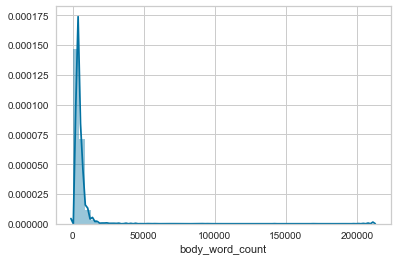

In [63]:
import seaborn as sns

sns.distplot(df['body_word_count'])
df['body_word_count'].describe()

In [64]:
# Vectorisation
from sklearn.feature_extraction.text import TfidfVectorizer

def vectorize(text, maxx_features):
    
    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

text = df['processed_text'].values
X = vectorize(text, 2 ** 12)
X.shape

(10000, 4096)

In [67]:
# PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(10000, 2175)

In [12]:
# Fonction pour faire du preprocessing d'un text

def preprocessText(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return tagged

def renderTaggedAbstract(uid, tag_list):
        print("Titre               : {}".format(metadata[metadata["cord_uid"] == uid]["title"].values[0]))
        print("Journal             : {}".format(metadata[metadata["cord_uid"] == uid]["journal"].values[0]))
        print("Date de publication : {} \n".format(metadata[metadata["cord_uid"] == uid]["publish_time"].values[0]))
        Visualizer = PosTagVisualizer()
        Visualizer.transform(tag_list)
        
# Tester les 2 fonctions sur les abstracts de 3 articles choisis aléatoirement

for i in range(3):
    index      = random.randint(0,NUMBER_OF_ARTICLES - 1)
    tagged     = preprocessText(abstracted.iloc[index]["abstract"])
    renderTaggedAbstract(abstracted.iloc[index]["cord_uid"], tagged)


Titre               : Medical retrieval and needs of infants with bronchiolitis: An analysis by gestational age
Journal             : J Paediatr Child Health
Date de publication : 2012-12-11 

AIM : Viral bronchiolitis is the most common lower respiratory tract infection in children less than 12 months of age . Prematurity is an independent risk factor for disease severity . Many infected infants require hospitalisation and those living in regional centres frequently require transfer to metropolitan hospitals capable of providing assisted ventilation . METHOD : We reviewed infants with bronchiolitis transported by the Victorian Newborn Emergency Transport Service between January 2003 and June 2007 . We compared the clinical presentation and treatment required by infants born preterm with those of their term counterparts . RESULTS : Of the 192 infants transported , 92 were born preterm . Preterm infants were younger at time of transport ( mean post‐menstrual age 41 weeks vs. 45 weeks ) 

## 1 ère Approche : Recherche grammaticale, avec les méthodes nltk

In [49]:
# Fonction pour faire du preprocessing d'un text
def preprocessText(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    return tagged


def renderTaggedAbstract(uid, tag_list):
        print("Titre               : {}".format(metadata[metadata["cord_uid"] == uid]["title"].values[0]))
        print("Journal             : {}".format(metadata[metadata["cord_uid"] == uid]["journal"].values[0]))
        print("Date de publication : {} \n".format(metadata[metadata["cord_uid"] == uid]["publish_time"].values[0]))
        Visualizer = PosTagVisualizer()
        Visualizer.transform(tag_list)
        
# Tester les 2 fonctions sur les abstracts de 3 articles choisis aléatoirement

for i in range(3):
    index      = random.randint(0,NUMBER_OF_ARTICLES - 1)
    tagged     = preprocessText(abstracted.iloc[index]["abstract"])
    renderTaggedAbstract(abstracted.iloc[index]["cord_uid"], tagged)
    

Titre               : Medical retrieval and needs of infants with bronchiolitis: An analysis by gestational age
Journal             : J Paediatr Child Health
Date de publication : 2012-12-11 

AIM : Viral bronchiolitis is the most common lower respiratory tract infection in children less than 12 months of age . Prematurity is an independent risk factor for disease severity . Many infected infants require hospitalisation and those living in regional centres frequently require transfer to metropolitan hospitals capable of providing assisted ventilation . METHOD : We reviewed infants with bronchiolitis transported by the Victorian Newborn Emergency Transport Service between January 2003 and June 2007 . We compared the clinical presentation and treatment required by infants born preterm with those of their term counterparts . RESULTS : Of the 192 infants transported , 92 were born preterm . Preterm infants were younger at time of transport ( mean post‐menstrual age 41 weeks vs. 45 weeks ) 

In [ ]:
# TODO : Identification des entités, et visualisation par catégorie
 
# TODO : Detection de région d'interet : Text matching | Recherche grammaticale | Recherche Relation entité 
# TODO : Règles d'extraction de réponse 

# TODO : [Prioritaire] Trouver dataset de validation, évolutif et non biaisé ??
( Connaissance de facteurs de risques : Obésité , fumer ... )

=> Intégrer le text complet
=> Filtrer sur les articles liés au Covid-19 ( )
=> extraction des facteurs de risques déja connus ()
=> clustering facteur de risques (partir sur les mots qu'on connait et chercher des similarités avec word-embedding, 
                                  partir aussi sur les contextes communs du mot risques )

=> Voir comment complémenter avec les word embeddings (mesure de similarité)

